<a id = "backtop"> </a>
# Table of Content

1. [Task 1](#Chapter1)  
   1.1 [Question 1](#Chapter1.1)  
   1.2 [Question 2](#Chapter1.2)  
   1.3 [Question 3](#Chapter1.3)
2. [Task 2](#Chapter2)  
   2.1 [Question 1](#Chapter2.1)  
   2.2 [Question 2](#Chapter2.2)  
   2.3 [Question 3](#Chapter2.3)  
3. [BONUS](#Chapter3)  
4. [RNN LSTM Future Forecast](#Chapter4)

<a id = "Chapter1"> </a>
# Task 1

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import time

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
csv_file = 'trends1.csv'
dst = pd.read_csv(csv_file)

In [3]:
dst

,Unnamed: 0,top 1,top 2,top 3,date
0,0,4,14,14,2012-10-07
1,1,7,15,18,2012-10-14
2,2,5,12,15,2012-10-21
3,3,5,15,12,2012-10-28
4,4,4,12,12,2012-11-04
...,...,...,...,...,...
256,256,18,72,35,2017-09-03
257,257,17,67,37,2017-09-10
258,258,18,66,32,2017-09-17
259,259,19,62,31,2017-09-24


In [4]:
dst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  261 non-null    int64 
 1   top 1       261 non-null    int64 
 2   top 2       261 non-null    int64 
 3   top 3       261 non-null    int64 
 4   date        261 non-null    object
dtypes: int64(4), object(1)
memory usage: 10.3+ KB


In [5]:
dst['date']= pd.to_datetime(dst['date'])

In [6]:
dst['Year'] = dst['date'].dt.year
dst['Month'] = dst['date'].dt.month

In [7]:
dst.drop(dst.columns[[0]], axis=1, inplace = True)

In [8]:
dst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   top 1   261 non-null    int64         
 1   top 2   261 non-null    int64         
 2   top 3   261 non-null    int64         
 3   date    261 non-null    datetime64[ns]
 4   Year    261 non-null    int64         
 5   Month   261 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 12.4 KB


In [9]:
dst

,top 1,top 2,top 3,date,Year,Month
0,4,14,14,2012-10-07,2012,10
1,7,15,18,2012-10-14,2012,10
2,5,12,15,2012-10-21,2012,10
3,5,15,12,2012-10-28,2012,10
4,4,12,12,2012-11-04,2012,11
...,...,...,...,...,...,...
256,18,72,35,2017-09-03,2017,9
257,17,67,37,2017-09-10,2017,9
258,18,66,32,2017-09-17,2017,9
259,19,62,31,2017-09-24,2017,9


## Moving Average

In [10]:
dst_ma = dst.copy()

In [11]:
top1v = dst_ma.iloc[:, 0].values
top2v = dst_ma.iloc[:, 1].values
top3v = dst_ma.iloc[:, 2].values

top1ma = []
top2ma = []
top3ma = []

def get_ma(ma_data):
        
    moving_averages = []
    i = 0

    while i < len(dst_ma):
        if i < 3:
            window_size = i
            window = ma_data[i - window_size: i + 1]
            
            if i == 0:
                window_average = round(sum(window) / 1, 2)
            else:
                window_average = round(sum(window) / (window_size + 1), 2)
            
        else:
            window_size = 4
            window = ma_data[i - window_size + 1: i + 1]
            window_average = round(sum(window) / window_size, 2)

            
        moving_averages.append(window_average)
        i += 1
        
    return moving_averages

In [12]:
top1ma = get_ma(top1v)
top2ma = get_ma(top2v)
top3ma = get_ma(top3v)

In [13]:
dst_ma['moving_average_top_1'] = top1ma
dst_ma['moving_average_top_2'] = top2ma
dst_ma['moving_average_top_3'] = top3ma

In [14]:
dst_ma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   top 1                 261 non-null    int64         
 1   top 2                 261 non-null    int64         
 2   top 3                 261 non-null    int64         
 3   date                  261 non-null    datetime64[ns]
 4   Year                  261 non-null    int64         
 5   Month                 261 non-null    int64         
 6   moving_average_top_1  261 non-null    float64       
 7   moving_average_top_2  261 non-null    float64       
 8   moving_average_top_3  261 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 18.5 KB


In [129]:
dst_ma.to_csv('top report.csv')

## Moving Forward

In [10]:
dst_gp_m = dst.copy()
dst_gp_m = dst_gp_m.groupby(['Year','Month']).mean()
dst_gp_m

top 1  top 2  top 3
Year Month                     
2012 10      5.25  14.00  14.75
     11      4.75  13.00  12.25
     12      5.00  13.40  12.20
2013 1       4.25  14.00  13.75
     2       3.75  17.50  14.25
...           ...    ...    ...
2017 6      18.50  93.50  40.25
     7      20.00  90.40  37.60
     8      18.75  74.50  35.25
     9      18.00  66.75  33.75
     10     20.00  78.00  27.00

[61 rows x 3 columns]

In [11]:
print(dst_gp_m.to_string())

            top 1  top 2  top 3
Year Month                     
2012 10      5.25  14.00  14.75
     11      4.75  13.00  12.25
     12      5.00  13.40  12.20
2013 1       4.25  14.00  13.75
     2       3.75  17.50  14.25
     3       4.60  17.20  15.60
     4       4.50  15.75  16.00
     5       3.50  17.50  14.75
     6       3.80  16.80  13.80
     7       4.00  16.00  14.25
     8       4.25  17.75  15.75
     9       4.40  17.00  15.00
     10      5.75  16.00  16.00
     11      4.50  15.00  14.50
     12      4.20  12.80  13.60
2014 1       4.75  15.00  15.25
     2       4.00  17.50  15.75
     3       4.20  20.80  18.00
     4       4.00  20.00  19.25
     5       4.50  19.75  22.25
     6       3.80  20.60  23.60
     7       4.50  21.75  26.50
     8       4.80  20.00  20.20
     9       5.25  18.50  18.75
     10      4.25  19.50  18.50
     11      4.60  15.40  16.20
     12      5.75  13.75  16.75
2015 1       5.25  17.25  15.75
     2       4.50  20.00  20.00
     3  

In [21]:
dst_gp_y = dst.copy()
dst_gp_y.drop('Month', axis=1, inplace = True)
dst_gp_y = dst_gp_y.groupby(['Year']).mean()
dst_gp_y

,top 1,top 2,top 3
Year,,,
2012,5.000000,13.461538,13.000000
2013,4.288462,16.096154,14.750000
2014,4.519231,18.596154,19.269231
2015,10.326923,23.634615,24.230769
2016,23.557692,61.826923,30.384615
2017,19.850000,75.850000,33.575000


In [22]:
year = [2012, 2013, 2014, 2015, 2016, 2017]
dst_gp_y['Year'] = year

In [23]:
dst_gp_y

,top 1,top 2,top 3,Year
Year,,,,
2012,5.000000,13.461538,13.000000,2012
2013,4.288462,16.096154,14.750000,2013
2014,4.519231,18.596154,19.269231,2014
2015,10.326923,23.634615,24.230769,2015
2016,23.557692,61.826923,30.384615,2016
2017,19.850000,75.850000,33.575000,2017


In [24]:
dst_gp_y.to_csv('year.csv')

In [15]:
plt.style.use("fivethirtyeight")
fig1, ax = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)

width = 0.2

label = dst_gp_y["Year"]
x = np.arange(len(label))

bar1 = ax.bar(x - width, dst_gp_y['top 1'], width = width, label = 'Top 1', edgecolor = "white", color = '#FF5833')
bar2 = ax.bar(x, dst_gp_y['top 2'], width = width, label = 'Top 2', edgecolor = "white", color = '#339FFF')
bar3 = ax.bar(x + width, dst_gp_y['top 3'], width = width, label = 'Top 3', edgecolor = "white", color = '#8EDD54')

ax.set_xlabel("Year", fontsize = 14, labelpad = 20)
ax.set_ylabel("Performance Score (%)", fontsize = 14, labelpad = 20)
ax.set_title("Annual Performance Scores for Different Tops", fontsize = 16, pad = 20)
ax.legend()

ax.set_xticks(x)
ax.set_xticklabels(label)

plt.close()

In [16]:
dst_gp_ma = dst_gp_m.iloc[39:51]
month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dst_gp_ma['Month'] = month
dst_gp_ma

C:\Users\US\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


top 1  top 2  top 3  Month
Year Month                            
2016 1      25.60  25.20  24.80      1
     2      27.25  33.50  29.25      2
     3      27.75  44.50  30.75      3
     4      25.75  55.00  33.00      4
     5      23.40  68.60  36.00      5
     6      22.00  85.25  37.50      6
     7      22.60  92.60  35.80      7
     8      20.50  82.75  30.75      8
     9      21.75  80.25  28.75      9
     10     22.00  62.20  27.20     10
     11     23.00  56.50  25.75     11
     12     21.25  55.25  24.50     12

In [17]:
plt.style.use("fivethirtyeight")
fig2, ax = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)

width = 0.2

label = dst_gp_ma['Month']
x = np.arange(len(label))

bar1 = ax.bar(x - width, dst_gp_ma['top 1'], width = width, label = 'Top 1', edgecolor = "white", color = '#FF5833')
bar2 = ax.bar(x, dst_gp_ma['top 2'], width = width, label = 'Top 2', edgecolor = "white", color = '#339FFF')
bar3 = ax.bar(x + width, dst_gp_ma['top 3'], width = width, label = 'Top 3', edgecolor = "white", color = '#8EDD54')

ax.set_xlabel("Month", fontsize = 14, labelpad = 20)
ax.set_ylabel("Performance Score (%)", fontsize = 14, labelpad = 20)
ax.set_title("Performance Scores for Different Tops in 2016", fontsize = 16, pad = 20)
ax.legend()

ax.set_xticks(x)
ax.set_xticklabels(label)

plt.close()

##### [Back to Top](#backtop)

<a id = "Chapter1.1"> </a>
## 1.1 Question 1

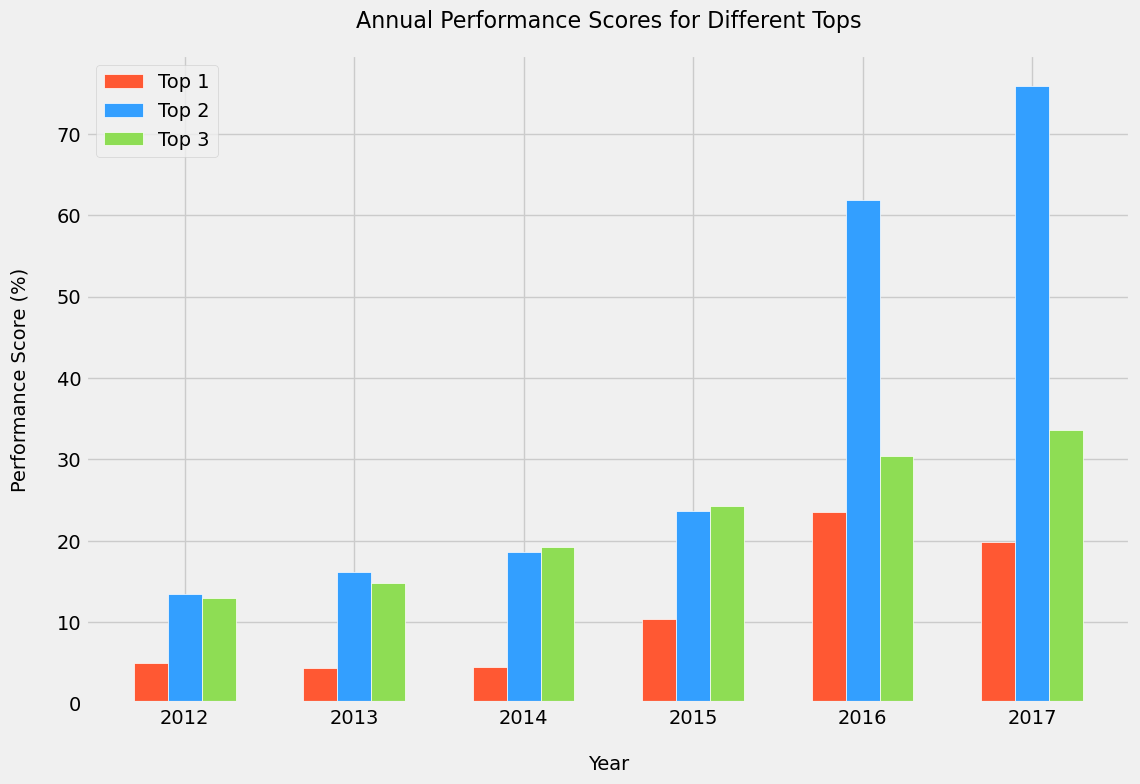

,top 1,top 2,top 3,Year
Year,,,,
2012,5.000000,13.461538,13.000000,2012
2013,4.288462,16.096154,14.750000,2013
2014,4.519231,18.596154,19.269231,2014
2015,10.326923,23.634615,24.230769,2015
2016,23.557692,61.826923,30.384615,2016
2017,19.850000,75.850000,33.575000,2017


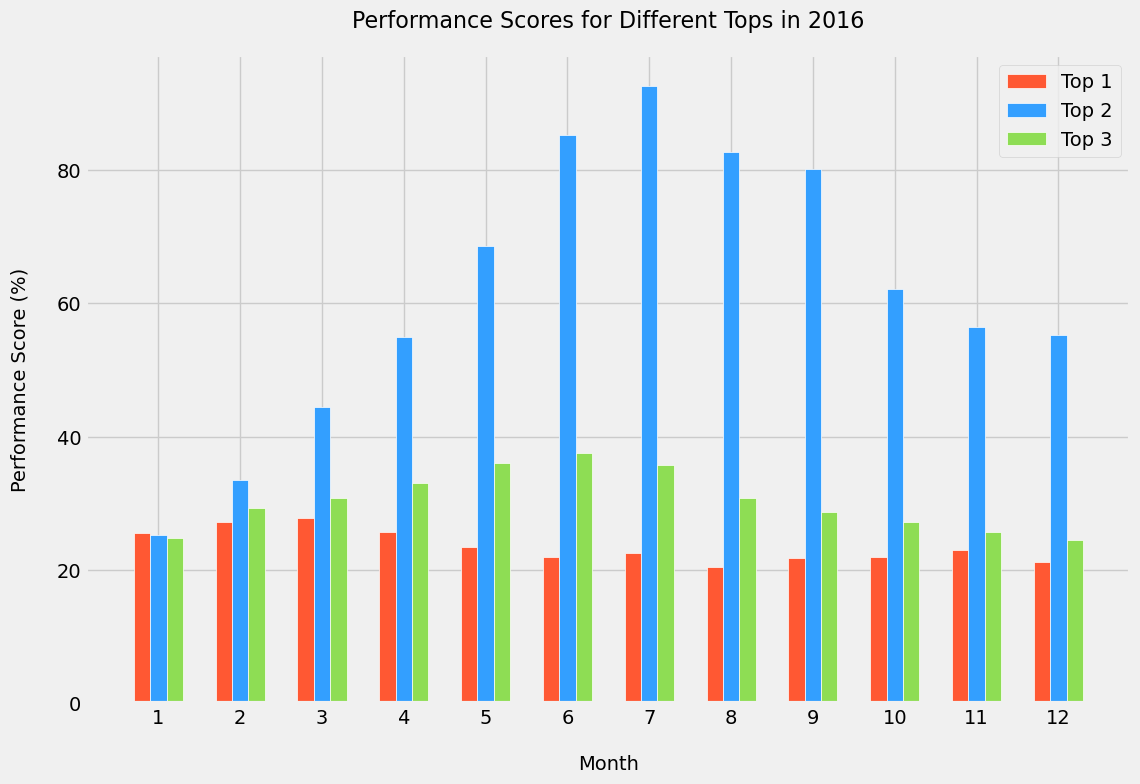

top 1  top 2  top 3  Month
Year Month                            
2016 1      25.60  25.20  24.80      1
     2      27.25  33.50  29.25      2
     3      27.75  44.50  30.75      3
     4      25.75  55.00  33.00      4
     5      23.40  68.60  36.00      5
     6      22.00  85.25  37.50      6
     7      22.60  92.60  35.80      7
     8      20.50  82.75  30.75      8
     9      21.75  80.25  28.75      9
     10     22.00  62.20  27.20     10
     11     23.00  56.50  25.75     11
     12     21.25  55.25  24.50     12

In [18]:
complete_figure = [fig1, fig2]
complete_table = [dst_gp_y, dst_gp_ma]

fig_count = 0

while fig_count < 2:
    display (complete_figure[fig_count])
    display (complete_table[fig_count])
    fig_count += 1

## Analysis for Fisrt Graph

---
The first graph shows the Annual Performance Scores for the 3 tops. The calculation is simple, the mean of performance scores in the whole year was taken into account for the 6 respective years. From the graph:  
1. Top 2 had been experiencing a steady albeit minimal increase in the first 4 years and an exponential increase after that.
2. Top 3 had been experiencing a steady increase in perfromance score throught the years as well but it was not as favourable as Top 2.
3. Top 1 on the other hand had been flatuating throughout the years and was generally relatively unfavorable as it has the lowest scores.

In conclusion, Top 2 was generally the most favourable piece throught the 6 years.

---

## Analysis for Second Graph

---

The second graph took into a deep look into the performance in 2016. The year 2017 was not taken because it wasn't a complete year. The calculation is simple, the mean of the performance scores for each month was taken into account for this analysis. From the graph:

1. All 3 pieces of tops were experiencing flactuations in general regarding their scores.
2. Top 2 and 3 peaked around mid-year (around June and July).
3. Top 1 was still the lowest in terms of performances throught the year.

In conclusion, Top 2 was the best in the year 2016.

---

##### [Back to Top](#backtop)

<a id = "Chapter1.2"> </a>
## 1.2 Question 2

In [19]:
dst_gp_mo = dst_gp_m.copy()
dst_gp_mo = dst_gp_m.iloc[48:60]
dst_gp_mo

top 1  top 2  top 3
Year Month                     
2016 10     22.00  62.20  27.20
     11     23.00  56.50  25.75
     12     21.25  55.25  24.50
2017 1      21.80  48.80  25.80
     2      19.75  58.75  27.00
     3      21.00  72.50  31.25
     4      21.20  86.20  35.00
     5      18.75  91.25  38.50
     6      18.50  93.50  40.25
     7      20.00  90.40  37.60
     8      18.75  74.50  35.25
     9      18.00  66.75  33.75

In [20]:
top1p = dst_gp_mo['top 1'].values.tolist()
top2p = dst_gp_mo['top 2'].values.tolist()
top3p = dst_gp_mo['top 3'].values.tolist()

In [21]:
class last_12m:
    def __init__(self, val1 = {}, val2 = {}, val3 = {}):
            self.val1 = val1
            self.val2 = val2
            self.val3 = val3
            
    def ave_score(self):
        
        mean_c = [self.val1, self.val2, self.val3]
        mean_r = [0, 0, 0]
        
        counter = 0
        
        while counter < 3:
            mean_r[counter] = mean(mean_c[counter])
            mean_r[counter] = "{:.2f}".format(mean_r[counter])
            counter += 1
            
        return mean_r


    
class perf_12m:
    def __init__(self, result = {}):
            self.result = result
            
    def print_dict(self):
        
        dic_result = {"top1:": "Top 1's performance for the last 12 months is " + self.result[0] + '%',
                      "top2:": "Top 2's performance for the last 12 months is " + self.result[1] + '%',
                      "top3:": "Top 3's performance for the last 12 months is " + self.result[2] + '%'}
        
        dictionary_items = dic_result.items()
        
        for item in dictionary_items:
            print(item)

##### [Back to Top](#backtop)

<a id = "Chapter1.3"> </a>
## 1.3 Question 3

In [22]:
ave_cal = last_12m(top1p, top2p, top3p)
myresult = ave_cal.ave_score()
myresult

['20.33', '71.38', '31.82']

In [23]:
print_result = perf_12m(myresult)
myprint = print_result.print_dict()

('top1:', "Top 1's performance for the last 12 months is 20.33%")
('top2:', "Top 2's performance for the last 12 months is 71.38%")
('top3:', "Top 3's performance for the last 12 months is 31.82%")


##### [Back to Top](#backtop)

<a id = "Chapter2"> </a>
# Task 2

In [11]:
csv_file = 'predictions.csv'
dst_p = pd.read_csv(csv_file)

In [12]:
dst_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  626 non-null    int64  
 1   date        626 non-null    object 
 2   fit top 1   626 non-null    float64
 3   fit top 2   626 non-null    float64
 4   fit top 3   626 non-null    float64
 5   fit2 top 3  626 non-null    float64
 6   fit3 top 3  626 non-null    float64
 7   fit2 top 2  626 non-null    float64
 8   fit3 top 2  626 non-null    float64
 9   fit2 top 1  626 non-null    float64
 10  fit3 top 1  626 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 53.9+ KB


In [13]:
dst_p

,Unnamed: 0,date,fit top 1,fit top 2,fit top 3,fit2 top 3,fit3 top 3,fit2 top 2,fit3 top 2,fit2 top 1,fit3 top 1
0,0,2012-10-07,6.464020,14.918372,12.852700,17.560586,16.691433,21.967562,19.348604,6.676299,6.814028
1,1,2012-10-14,6.405044,14.879459,13.460605,17.584433,16.864402,20.428943,18.149665,6.553469,6.678460
2,2,2012-10-21,5.594880,12.766397,12.500809,16.287381,15.672930,17.533925,15.621429,5.685904,5.801919
3,3,2012-10-28,4.556118,9.883558,11.040882,14.667064,14.128378,14.478612,13.020325,4.598339,4.706192
4,4,2012-11-04,4.203193,8.345088,10.553082,14.029395,13.566908,12.894532,11.970428,4.200978,4.297650
...,...,...,...,...,...,...,...,...,...,...,...
621,621,2018-09-27,16.588328,98.782168,36.344867,36.316258,36.037766,73.258258,64.549945,17.507205,17.533665
622,622,2018-09-28,16.655365,98.884051,36.503322,36.415425,36.139121,73.103604,64.319097,17.567572,17.594394
623,623,2018-09-29,16.724295,99.019655,36.689969,36.538825,36.265359,72.967858,64.104769,17.629760,17.656862
624,624,2018-09-30,16.794364,99.184409,36.900044,36.682254,36.412168,72.847916,63.903832,17.693017,17.720324


In [14]:
dst_p['date']= pd.to_datetime(dst_p['date'])
dst_p['Year'] = dst_p['date'].dt.year
dst_p['Month'] = dst_p['date'].dt.month

In [15]:
dst_p

,Unnamed: 0,date,fit top 1,fit top 2,fit top 3,fit2 top 3,fit3 top 3,fit2 top 2,fit3 top 2,fit2 top 1,fit3 top 1,Year,Month
0,0,2012-10-07,6.464020,14.918372,12.852700,17.560586,16.691433,21.967562,19.348604,6.676299,6.814028,2012,10
1,1,2012-10-14,6.405044,14.879459,13.460605,17.584433,16.864402,20.428943,18.149665,6.553469,6.678460,2012,10
2,2,2012-10-21,5.594880,12.766397,12.500809,16.287381,15.672930,17.533925,15.621429,5.685904,5.801919,2012,10
3,3,2012-10-28,4.556118,9.883558,11.040882,14.667064,14.128378,14.478612,13.020325,4.598339,4.706192,2012,10
4,4,2012-11-04,4.203193,8.345088,10.553082,14.029395,13.566908,12.894532,11.970428,4.200978,4.297650,2012,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,621,2018-09-27,16.588328,98.782168,36.344867,36.316258,36.037766,73.258258,64.549945,17.507205,17.533665,2018,9
622,622,2018-09-28,16.655365,98.884051,36.503322,36.415425,36.139121,73.103604,64.319097,17.567572,17.594394,2018,9
623,623,2018-09-29,16.724295,99.019655,36.689969,36.538825,36.265359,72.967858,64.104769,17.629760,17.656862,2018,9
624,624,2018-09-30,16.794364,99.184409,36.900044,36.682254,36.412168,72.847916,63.903832,17.693017,17.720324,2018,9


In [16]:
dst_p.drop(dst_p.columns[[0]], axis=1, inplace = True)

In [17]:
dst_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        626 non-null    datetime64[ns]
 1   fit top 1   626 non-null    float64       
 2   fit top 2   626 non-null    float64       
 3   fit top 3   626 non-null    float64       
 4   fit2 top 3  626 non-null    float64       
 5   fit3 top 3  626 non-null    float64       
 6   fit2 top 2  626 non-null    float64       
 7   fit3 top 2  626 non-null    float64       
 8   fit2 top 1  626 non-null    float64       
 9   fit3 top 1  626 non-null    float64       
 10  Year        626 non-null    int64         
 11  Month       626 non-null    int64         
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 58.8 KB


In [18]:
dst_p

,date,fit top 1,fit top 2,fit top 3,fit2 top 3,fit3 top 3,fit2 top 2,fit3 top 2,fit2 top 1,fit3 top 1,Year,Month
0,2012-10-07,6.464020,14.918372,12.852700,17.560586,16.691433,21.967562,19.348604,6.676299,6.814028,2012,10
1,2012-10-14,6.405044,14.879459,13.460605,17.584433,16.864402,20.428943,18.149665,6.553469,6.678460,2012,10
2,2012-10-21,5.594880,12.766397,12.500809,16.287381,15.672930,17.533925,15.621429,5.685904,5.801919,2012,10
3,2012-10-28,4.556118,9.883558,11.040882,14.667064,14.128378,14.478612,13.020325,4.598339,4.706192,2012,10
4,2012-11-04,4.203193,8.345088,10.553082,14.029395,13.566908,12.894532,11.970428,4.200978,4.297650,2012,11
...,...,...,...,...,...,...,...,...,...,...,...,...
621,2018-09-27,16.588328,98.782168,36.344867,36.316258,36.037766,73.258258,64.549945,17.507205,17.533665,2018,9
622,2018-09-28,16.655365,98.884051,36.503322,36.415425,36.139121,73.103604,64.319097,17.567572,17.594394,2018,9
623,2018-09-29,16.724295,99.019655,36.689969,36.538825,36.265359,72.967858,64.104769,17.629760,17.656862,2018,9
624,2018-09-30,16.794364,99.184409,36.900044,36.682254,36.412168,72.847916,63.903832,17.693017,17.720324,2018,9


## Moving Average

In [23]:
top1pv1 = dst_p.iloc[:, 1].values
top1pv2 = dst_p.iloc[:, 8].values
top1pv3 = dst_p.iloc[:, 9].values
top1ma1 = []
top1ma2 = []
top1ma3 = []

top2pv1 = dst_p.iloc[:, 2].values
top2pv2 = dst_p.iloc[:, 6].values
top2pv3 = dst_p.iloc[:, 7].values
top2ma1 = []
top2ma2 = []
top2ma3 = []

top3pv1 = dst_p.iloc[:, 3].values
top3pv2 = dst_p.iloc[:, 4].values
top3pv3 = dst_p.iloc[:, 5].values
top3ma1 = []
top3ma2 = []
top3ma3 = []



def get_ma(ma_data):
        
    moving_averages = []
    i = 0

    while i < len(dst_p):
        if i < 3:
            window_size = i
            window = ma_data[i - window_size: i + 1]
            
            if i == 0:
                window_average = round(sum(window) / 1, 2)
            else:
                window_average = round(sum(window) / (window_size + 1), 2)
            
        else:
            window_size = 4
            window = ma_data[i - window_size + 1: i + 1]
            window_average = round(sum(window) / window_size, 2)

            
        moving_averages.append(window_average)
        i += 1
        
    return moving_averages

In [24]:
top1ma1 = get_ma(top1pv1)
top1ma2 = get_ma(top1pv2)
top1ma3 = get_ma(top1pv3)

top2ma1 = get_ma(top2pv1)
top2ma2 = get_ma(top2pv2)
top2ma3 = get_ma(top2pv3)

top3ma1 = get_ma(top3pv1)
top3ma2 = get_ma(top3pv2)
top3ma3 = get_ma(top3pv3)

In [25]:
dst_my = pd.DataFrame()

dst_my['moving_average_top_1.1'] = top1ma1
dst_my['moving_average_top_1.2'] = top1ma2
dst_my['moving_average_top_1.3'] = top1ma3

dst_my['moving_average_top_2.1'] = top2ma1
dst_my['moving_average_top_2.2'] = top2ma2
dst_my['moving_average_top_2.3'] = top2ma3

dst_my['moving_average_top_3.1'] = top3ma1
dst_my['moving_average_top_3.2'] = top3ma2
dst_my['moving_average_top_3.3'] = top3ma3

In [26]:
dst_my

,moving_average_top_1.1,moving_average_top_1.2,moving_average_top_1.3,moving_average_top_2.1,moving_average_top_2.2,moving_average_top_2.3,moving_average_top_3.1,moving_average_top_3.2,moving_average_top_3.3
0,6.46,6.68,6.81,14.92,21.97,19.35,12.85,17.56,16.69
1,6.43,6.61,6.75,14.90,21.20,18.75,13.16,17.57,16.78
2,6.15,6.31,6.43,14.19,19.98,17.71,12.94,17.14,16.41
3,5.76,5.88,6.00,13.11,18.60,16.54,12.46,16.52,15.84
4,5.19,5.26,5.37,11.47,16.33,14.69,11.89,15.64,15.06
...,...,...,...,...,...,...,...,...,...
621,16.49,17.42,17.45,98.73,73.55,64.95,36.19,36.24,35.96
622,16.56,17.48,17.51,98.77,73.36,64.68,36.30,36.30,36.02
623,16.62,17.54,17.57,98.85,73.19,64.44,36.44,36.38,36.10
624,16.69,17.60,17.63,98.97,73.04,64.22,36.61,36.49,36.21


In [27]:
dst_ori = pd.DataFrame()

dst_ori['date'] = dst['date']
dst_ori['my_top_1'] = dst_ma['moving_average_top_1']
dst_ori['my_top_2'] = dst_ma['moving_average_top_2']
dst_ori['my_top_3'] = dst_ma['moving_average_top_3']

In [37]:
dst_ori

,date,my_top_1,my_top_2,my_top_3
0,2012-10-07,4.00,14.00,14.00
1,2012-10-14,5.50,14.50,16.00
2,2012-10-21,5.33,13.67,15.67
3,2012-10-28,5.25,14.00,14.75
4,2012-11-04,5.25,13.50,14.25
...,...,...,...,...
256,2017-09-03,18.50,73.25,35.00
257,2017-09-10,17.75,71.50,35.50
258,2017-09-17,17.50,69.75,35.00
259,2017-09-24,18.00,66.75,33.75


In [38]:
dst_my.to_csv('prediction report.csv')
dst_ori.to_csv('original trend.csv')

## Moving Forward

In [19]:
dst_p_gp = dst_p.copy()
dst_p_gp = dst_p.groupby(['Year','Month']).mean().reset_index()
dst_p_gp['Date'] = pd.to_datetime(dst_p_gp.assign(Day = 1).loc[:, ['Year','Month','Day']])

In [20]:
dst_p_gp

,Year,Month,fit top 1,fit top 2,fit top 3,fit2 top 3,fit3 top 3,fit2 top 2,fit3 top 2,fit2 top 1,fit3 top 1,Date
0,2012,10,5.755016,13.111947,12.463749,16.524866,15.839286,18.602261,16.535006,5.878503,6.000150,2012-10-01
1,2012,11,5.428707,9.752933,11.704611,14.827010,14.522483,13.903530,13.840885,5.356069,5.431922,2012-11-01
2,2012,12,5.948125,8.029548,9.730182,12.096328,12.315548,11.808571,12.998270,5.675017,5.695157,2012-12-01
3,2013,1,6.529270,8.118225,11.773971,13.445924,14.209143,12.483182,13.853127,6.111906,6.075371,2013-01-01
4,2013,2,5.645324,11.790157,13.631167,14.445908,15.322559,16.065901,17.618843,5.178063,5.106981,2013-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...
68,2018,6,15.697004,106.723235,43.340545,43.772180,43.953543,90.609365,88.664642,16.701088,16.798593,2018-06-01
69,2018,7,16.125648,108.508767,42.593004,43.017256,43.173517,90.614713,86.711461,17.233806,17.276058,2018-07-01
70,2018,8,15.633321,103.170540,40.227162,40.573588,40.600767,81.833488,75.732888,16.767274,16.772305,2018-08-01
71,2018,9,15.934155,100.566332,37.914747,38.091437,37.875788,76.450642,68.465279,16.925763,16.941434,2018-09-01


In [21]:
dst_p_gp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Year        73 non-null     int64         
 1   Month       73 non-null     int64         
 2   fit top 1   73 non-null     float64       
 3   fit top 2   73 non-null     float64       
 4   fit top 3   73 non-null     float64       
 5   fit2 top 3  73 non-null     float64       
 6   fit3 top 3  73 non-null     float64       
 7   fit2 top 2  73 non-null     float64       
 8   fit3 top 2  73 non-null     float64       
 9   fit2 top 1  73 non-null     float64       
 10  fit3 top 1  73 non-null     float64       
 11  Date        73 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 7.0 KB


In [22]:
dst_t_m = dst.copy()
dst_t_m = dst_t_m.groupby(['Year','Month']).mean().reset_index()
dst_t_m['Date'] = pd.to_datetime(dst_t_m.assign(Day = 1).loc[:, ['Year','Month','Day']])

In [23]:
dst_t_m

,Year,Month,top 1,top 2,top 3,Date
0,2012,10,5.25,14.00,14.75,2012-10-01
1,2012,11,4.75,13.00,12.25,2012-11-01
2,2012,12,5.00,13.40,12.20,2012-12-01
3,2013,1,4.25,14.00,13.75,2013-01-01
4,2013,2,3.75,17.50,14.25,2013-02-01
...,...,...,...,...,...,...
56,2017,6,18.50,93.50,40.25,2017-06-01
57,2017,7,20.00,90.40,37.60,2017-07-01
58,2017,8,18.75,74.50,35.25,2017-08-01
59,2017,9,18.00,66.75,33.75,2017-09-01


In [24]:
dst_t_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Year    61 non-null     int64         
 1   Month   61 non-null     int64         
 2   top 1   61 non-null     float64       
 3   top 2   61 non-null     float64       
 4   top 3   61 non-null     float64       
 5   Date    61 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 3.0 KB


In [36]:
plt.style.use('default')


fig4, ax1 = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)

ax1.plot(dst_t_m['Date'], dst_t_m['top 1'], label = "Trend", color = '#FF5833')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit top 1'], label = "Fitted Model 1", color = '#339FFF')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit2 top 1'], label = "Fitted Model 2", color = '#8EDD54')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit3 top 1'], label = "Fitted Model 3", color = '#9961CB')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.set_xlabel("Timestamp", fontsize = 14, labelpad = 20)
ax1.set_ylabel("Performance Score (%)", fontsize = 14, labelpad = 20)
ax1.set_title("Performance Score Predictions for Top 1", fontsize = 16, pad = 20)
ax1.legend()
ax1.grid(True)
plt.xticks(rotation = 90)

plt.close()



fig5, ax1 = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)

ax1.plot(dst_t_m['Date'], dst_t_m['top 2'], label = "Trend", color = '#FF5833')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit top 2'], label = "Fitted Model 1", color = '#339FFF')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit2 top 2'], label = "Fitted Model 2", color = '#8EDD54')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit3 top 2'], label = "Fitted Model 3", color = '#9961CB')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.set_xlabel("Timestamp", fontsize = 14, labelpad = 20)
ax1.set_ylabel("Performance Score (%)", fontsize = 14, labelpad = 20)
ax1.set_title("Performance Score Predictions for Top 2", fontsize = 16, pad = 20)
ax1.legend()
ax1.grid(True)
plt.xticks(rotation = 90)

plt.close()



fig6, ax1 = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)

ax1.plot(dst_t_m['Date'], dst_t_m['top 3'], label = "Trend", color = '#FF5833')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit top 3'], label = "Fitted Model 1", color = '#339FFF')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit2 top 3'], label = "Fitted Model 2", color = '#8EDD54')
ax1.plot(dst_p_gp['Date'], dst_p_gp['fit3 top 3'], label = "Fitted Model 3", color = '#9961CB')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.set_xlabel("Timestamp", fontsize = 14, labelpad = 20)
ax1.set_ylabel("Performance Score (%)", fontsize = 14, labelpad = 20)
ax1.set_title("Performance Score Predictions for Top 3", fontsize = 16, pad = 20)
ax1.legend()
ax1.grid(True)
plt.xticks(rotation = 90)

plt.close()

##### [Back to Top](#backtop)

<a id = "Chapter2.1"> </a>
## 2.1 Question 1

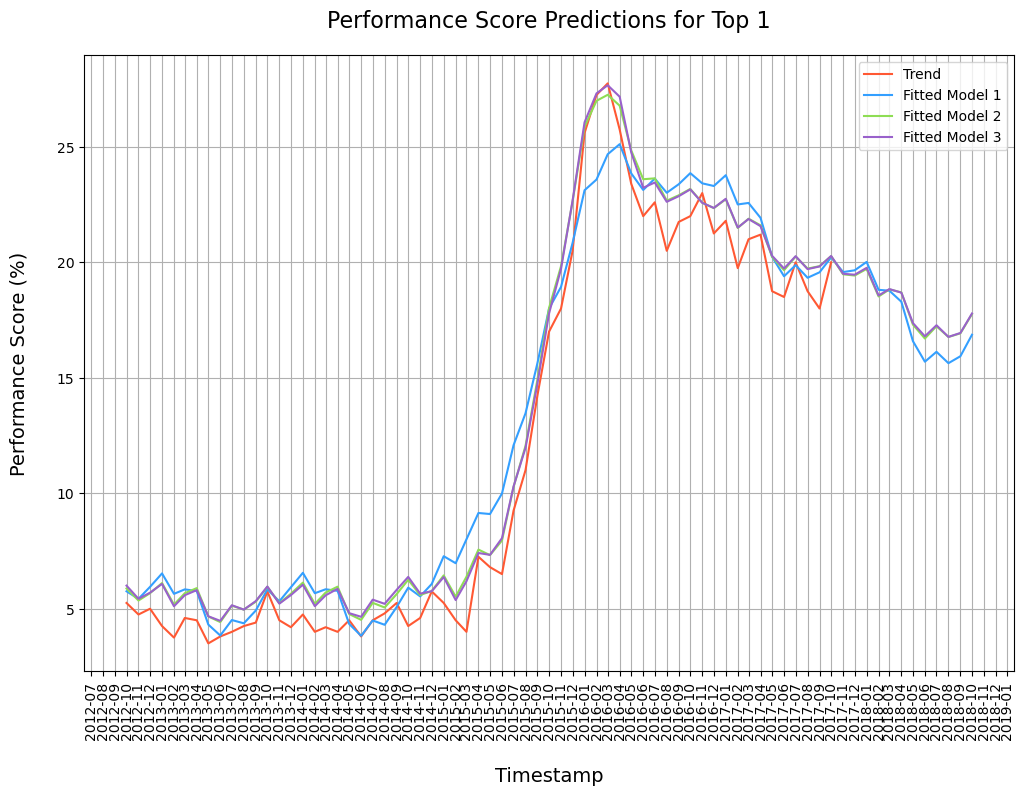

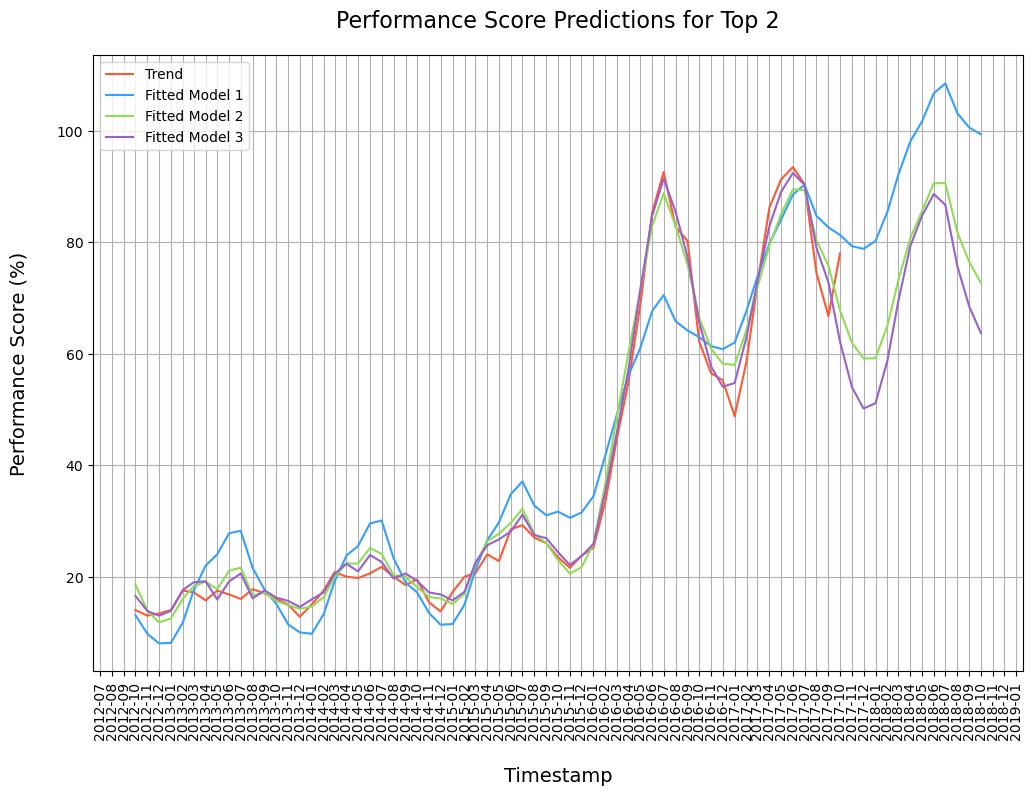

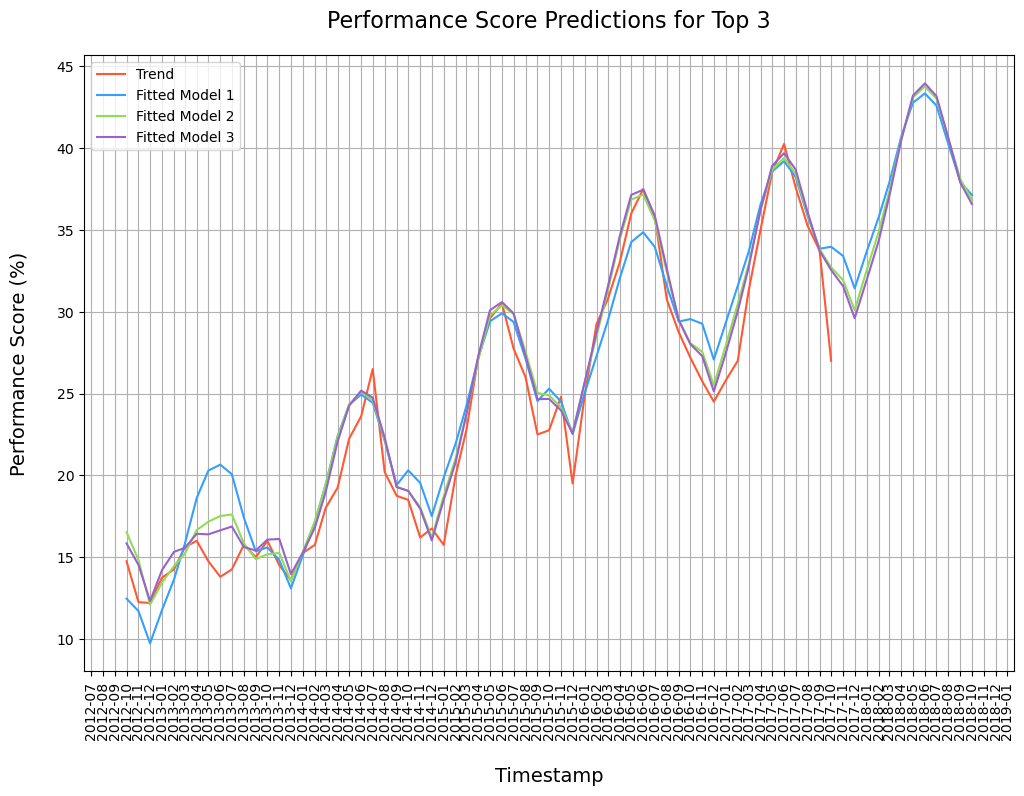

In [37]:
complete_figure2 = [fig4, fig5, fig6]

fig_count = 0

while fig_count < 3:
    display (complete_figure2[fig_count])
    fig_count += 1

## Analysis on the Fitted Models

---

The general rule of thumb is that the closer the model fit tot original data, the better the model performance is.
1. For Top 1, Model 3 seemed to be the best fitas it closely followed the trend of the original data (flactuations i.e.). However, Model 2 would have been a close second.
2. Again, Model 3 was a better fit for Top 2. It was more obvious this time as the other models seemed to not quite follow the trend of the original data as closely.
3. Model 3 was still the best for Top 3. Although in this case, it became slightly worrying that the model don't quite follow the trends in the original data, but it was still good nonetheless.

In conclusion, Model 3 seemed to be the best fir for all 3 tops in general.

---

##### [Back to Top](#backtop)

<a id = "Chapter2.2"> </a>
## 2.2 Question 2

1. According to the fitted model 3, Top 1 will be experiencing a steady drop in the next 12 months in general.
2. According to the fitted model 3, Top 2 will be experiencing a steady drop in the next 3 months (approx.) but will rise up steadily and peak around June/July, then again fall steadily afterwards.
3. According to the fitted model 3, Top 3 will first drop in the next 2 months, rising up and peaking around June/July (similar to Top 2 as discussed in previous section) and dropping down afterwards.

##### [Back to Top](#backtop)

<a id = "Chapter2.3"> </a>
## 2.3 Question 3

## Random Forest Regression for Top 1

In [60]:
dst_t_m['Date2'] = dst_t_m['Date'].map(dt.datetime.toordinal)

In [61]:
x = dst_t_m.iloc[:, -1].values
y = dst_t_m.iloc[:, 2].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [62]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train, y_train)

<ipython-input-62-19c84054ec94>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

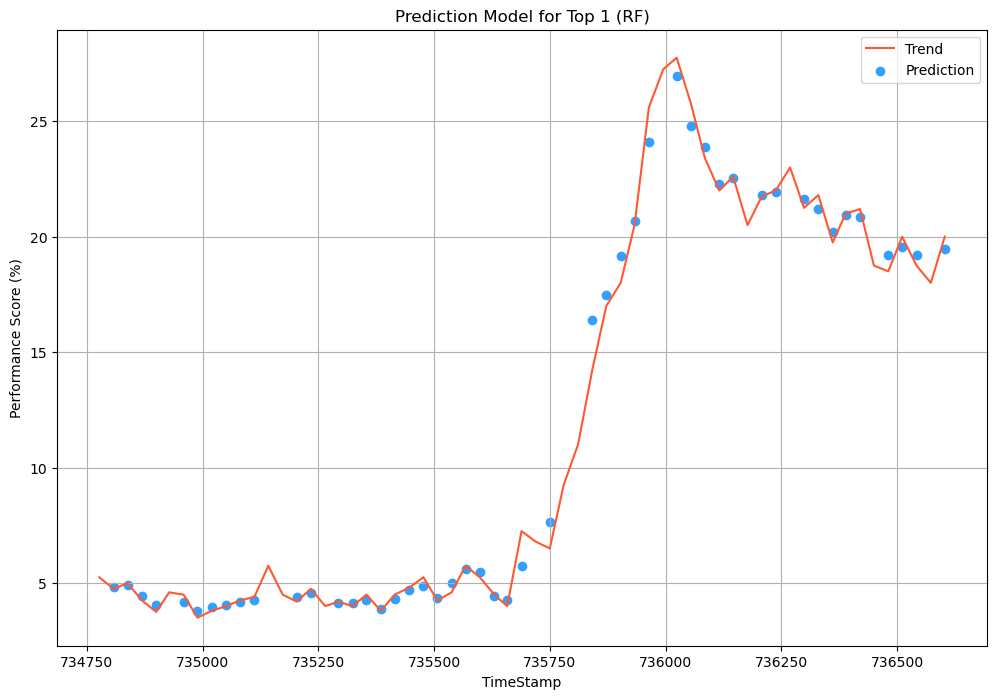

In [63]:
fig = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(x, y, label = "Trend", color = '#FF5833')
plt.scatter(x_train, regressor.predict(x_train), label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 1 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

## Moving Average

In [37]:
dst_ma['Date2'] = dst_ma['date'].map(dt.datetime.toordinal)

In [38]:
dst_ma

,top 1,top 2,top 3,date,Year,Month,moving_average_top_1,moving_average_top_2,moving_average_top_3,Date2
0,4,14,14,2012-10-07,2012,10,4.00,14.00,14.00,734783
1,7,15,18,2012-10-14,2012,10,5.50,14.50,16.00,734790
2,5,12,15,2012-10-21,2012,10,5.33,13.67,15.67,734797
3,5,15,12,2012-10-28,2012,10,5.25,14.00,14.75,734804
4,4,12,12,2012-11-04,2012,11,5.25,13.50,14.25,734811
...,...,...,...,...,...,...,...,...,...,...
256,18,72,35,2017-09-03,2017,9,18.50,73.25,35.00,736575
257,17,67,37,2017-09-10,2017,9,17.75,71.50,35.50,736582
258,18,66,32,2017-09-17,2017,9,17.50,69.75,35.00,736589
259,19,62,31,2017-09-24,2017,9,18.00,66.75,33.75,736596


In [39]:
x = dst_ma.iloc[:, -1].values
y = dst_ma.iloc[:, -4].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [40]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train, y_train)
y_pred =  regressor.predict(x_train)

<ipython-input-40-5d740f53352e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


In [41]:
y_pred = y_pred.reshape(-1, 1)
fitted_model_1 = np.concatenate((x_train, y_pred), axis=1)
fitted_model_1 = fitted_model_1[fitted_model_1[:, 0].argsort()]

In [42]:
original_trend_1 = np.concatenate((x_train, y_train), axis=1)
original_trend_1 = original_trend_1[original_trend_1[:, 0].argsort()]

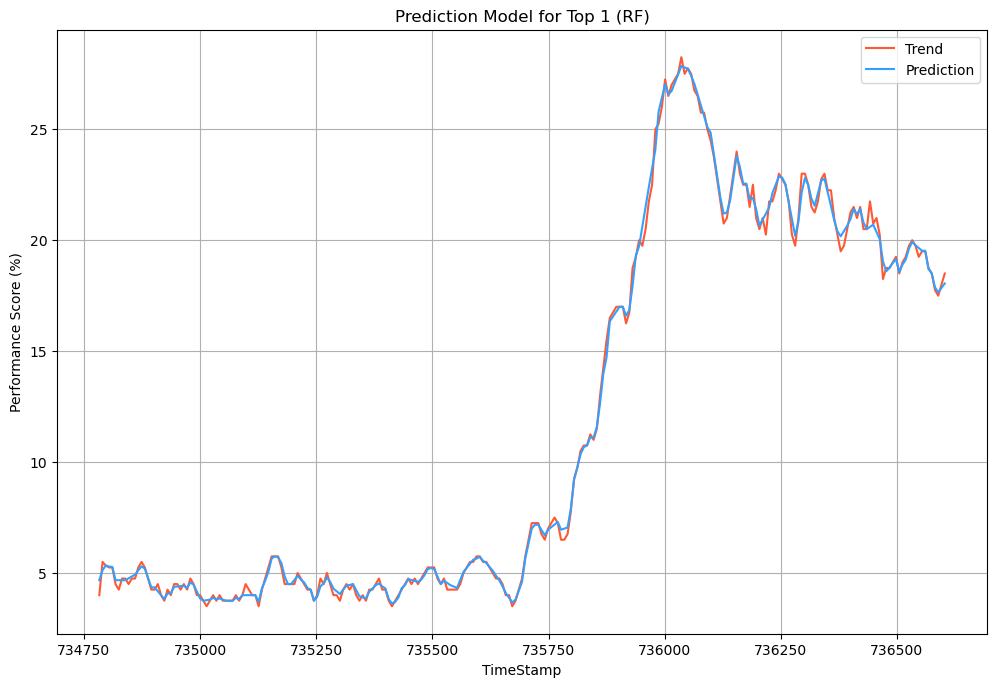

In [33]:
fig = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(x, y, label = "Trend", color = '#FF5833')
plt.plot(fitted_model_1[:, 0], fitted_model_1[:, 1], label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 1 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

## Random Forest Regression for Top 2

In [92]:
dst_t_m['Date2'] = dst_t_m['Date'].map(dt.datetime.toordinal)

In [93]:
x = dst_t_m.iloc[:, -1].values
y = dst_t_m.iloc[:, 3].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [96]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train, y_train)

<ipython-input-96-19c84054ec94>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

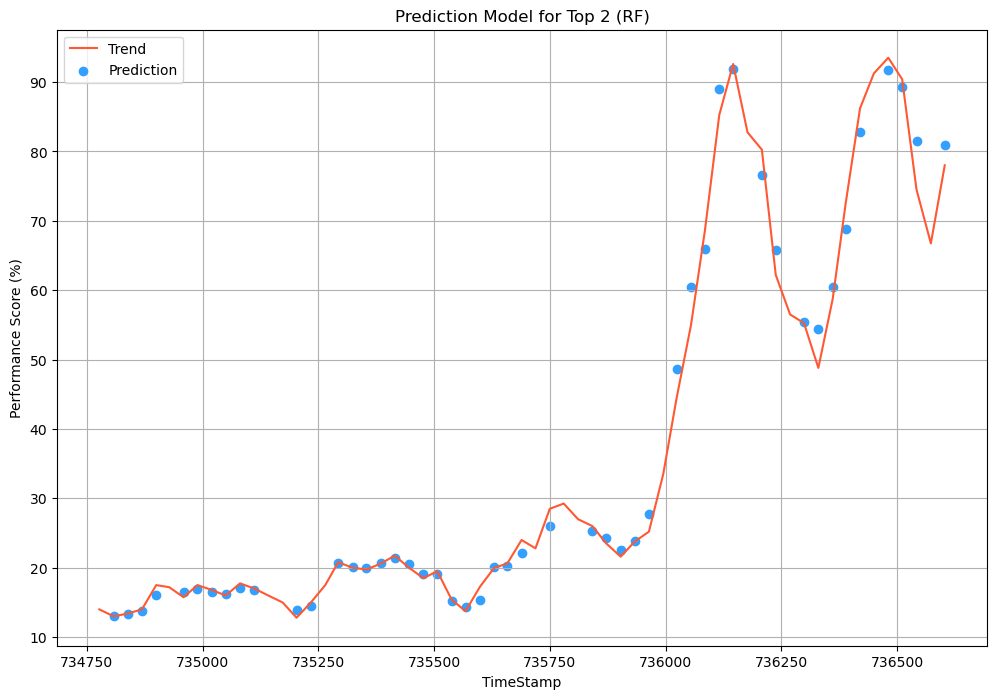

In [97]:
fig = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(x, y, label = "Trend", color = '#FF5833')
plt.scatter(x_train, regressor.predict(x_train), label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 2 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

## Moving Averge

In [43]:
dst_ma['Date2'] = dst_ma['date'].map(dt.datetime.toordinal)

In [44]:
x = dst_ma.iloc[:, -1].values
y = dst_ma.iloc[:, -3].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [45]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train, y_train)
y_pred =  regressor.predict(x_train)

<ipython-input-45-5d740f53352e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


In [46]:
y_pred = y_pred.reshape(-1, 1)
fitted_model_2 = np.concatenate((x_train, y_pred), axis=1)
fitted_model_2 = fitted_model_2[fitted_model_2[:, 0].argsort()]

In [47]:
original_trend_2 = np.concatenate((x_train, y_train), axis=1)
original_trend_2 = original_trend_2[original_trend_2[:, 0].argsort()]

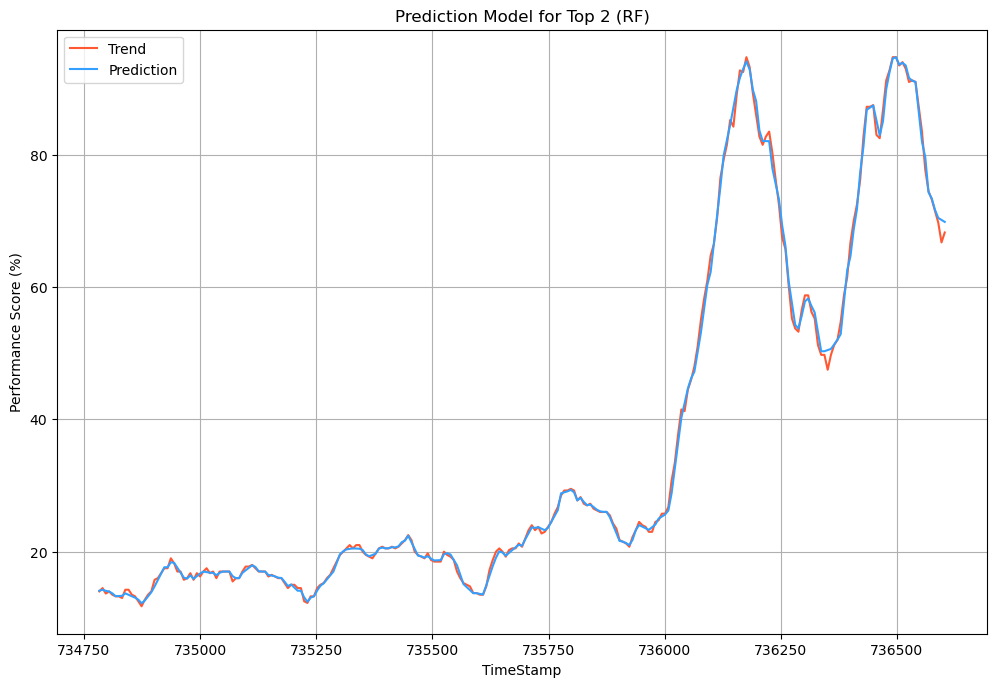

In [48]:
fig = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(x, y, label = "Trend", color = '#FF5833')
plt.plot(fitted_model_2[:, 0], fitted_model_2[:, 1], label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 2 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

## Random Forest Regression for Top 3

In [45]:
x = dst_t_m.iloc[:, -1].values
y = dst_t_m.iloc[:, 4].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [46]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train, y_train)

<ipython-input-46-19c84054ec94>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

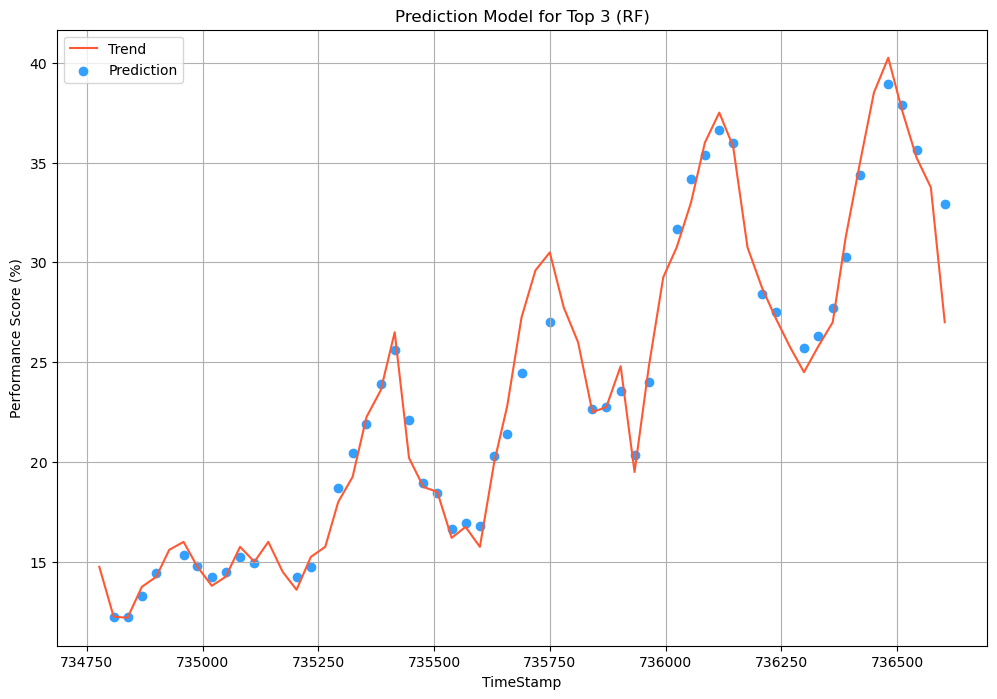

In [47]:
fig = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(x, y, label = "Trend", color = '#FF5833')
plt.scatter(x_train, regressor.predict(x_train), label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 3 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

## Moving Average

In [49]:
dst_ma['Date2'] = dst_ma['date'].map(dt.datetime.toordinal)

In [50]:
x = dst_ma.iloc[:, -1].values
y = dst_ma.iloc[:, -2].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [51]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train, y_train)
y_pred =  regressor.predict(x_train)

<ipython-input-51-5d740f53352e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


In [52]:
y_pred = y_pred.reshape(-1, 1)
fitted_model_3 = np.concatenate((x_train, y_pred), axis=1)
fitted_model_3 = fitted_model_3[fitted_model_3[:, 0].argsort()]

In [53]:
original_trend_3 = np.concatenate((x_train, y_train), axis=1)
original_trend_3 = original_trend_3[original_trend_3[:, 0].argsort()]

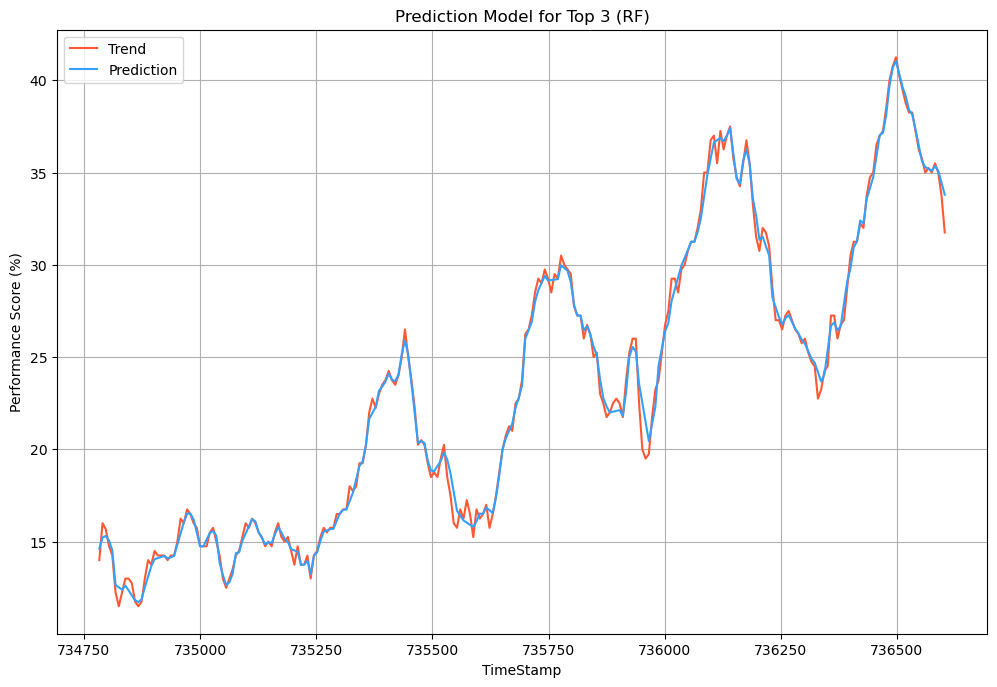

In [54]:
fig = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(x, y, label = "Trend", color = '#FF5833')
plt.plot(fitted_model_3[:, 0], fitted_model_3[:, 1], label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 3 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

In [55]:
fitted_model_final = np.concatenate((fitted_model_1, fitted_model_2), axis=1)
fitted_model_final = np.concatenate((fitted_model_final, fitted_model_3), axis=1)

In [56]:
dst_my_pred = pd.DataFrame()

dst_my_pred['timestamp'] = fitted_model_final[:, 0]
dst_my_pred['fitted_model_1'] = fitted_model_final[:, 1]
dst_my_pred['original_trend_1'] = original_trend_1[:, 1]
dst_my_pred['fitted_model_2'] = fitted_model_final[:, 3]
dst_my_pred['original_trend_2'] = original_trend_2[:, 1]
dst_my_pred['fitted_model_3'] = fitted_model_final[:, 5]
dst_my_pred['original_trend_3'] = original_trend_3[:, 1]

In [57]:
dst_my_pred

,timestamp,fitted_model_1,original_trend_1,fitted_model_2,original_trend_2,fitted_model_3,original_trend_3
0,734783.0,4.675,4.00,14.100,14.00,14.625,14.00
1,734790.0,5.125,5.50,14.250,14.50,15.225,16.00
2,734797.0,5.341,5.33,14.084,13.67,15.309,15.67
3,734804.0,5.291,5.25,13.984,14.00,15.059,14.75
4,734811.0,5.275,5.25,13.700,13.50,14.525,14.25
...,...,...,...,...,...,...,...
203,736568.0,18.700,18.75,74.350,74.50,35.200,35.25
204,736575.0,18.500,18.50,73.400,73.25,35.100,35.00
205,736582.0,17.875,17.75,71.675,71.50,35.350,35.50
206,736589.0,17.650,17.50,70.450,69.75,35.100,35.00


In [58]:
dst_my_pred['timestamp'] = dst_my_pred['timestamp'].astype(int)
dst_my_pred['timestamp'] = dst_my_pred['timestamp'].apply(dt.datetime.fromordinal)

In [59]:
dst_my_pred

,timestamp,fitted_model_1,original_trend_1,fitted_model_2,original_trend_2,fitted_model_3,original_trend_3
0,2012-10-07,4.675,4.00,14.100,14.00,14.625,14.00
1,2012-10-14,5.125,5.50,14.250,14.50,15.225,16.00
2,2012-10-21,5.341,5.33,14.084,13.67,15.309,15.67
3,2012-10-28,5.291,5.25,13.984,14.00,15.059,14.75
4,2012-11-04,5.275,5.25,13.700,13.50,14.525,14.25
...,...,...,...,...,...,...,...
203,2017-08-27,18.700,18.75,74.350,74.50,35.200,35.25
204,2017-09-03,18.500,18.50,73.400,73.25,35.100,35.00
205,2017-09-10,17.875,17.75,71.675,71.50,35.350,35.50
206,2017-09-17,17.650,17.50,70.450,69.75,35.100,35.00


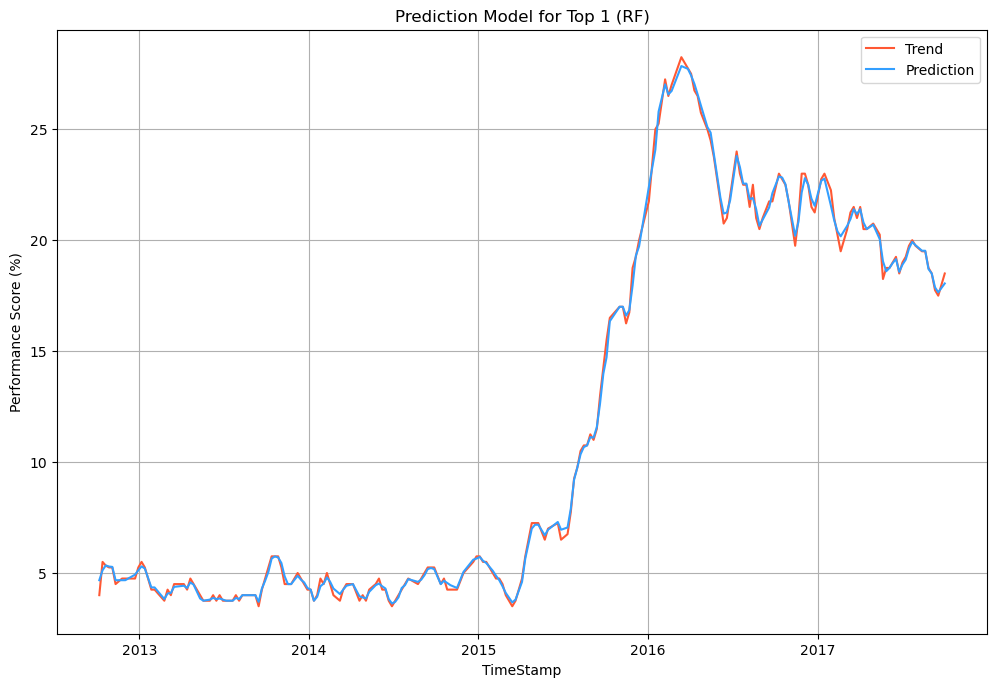

In [91]:
fig11 = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(dst_my_pred['timestamp'], dst_my_pred['original_trend_1'], label = "Trend", color = '#FF5833')
plt.plot(dst_my_pred['timestamp'], dst_my_pred['fitted_model_1'], label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 1 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

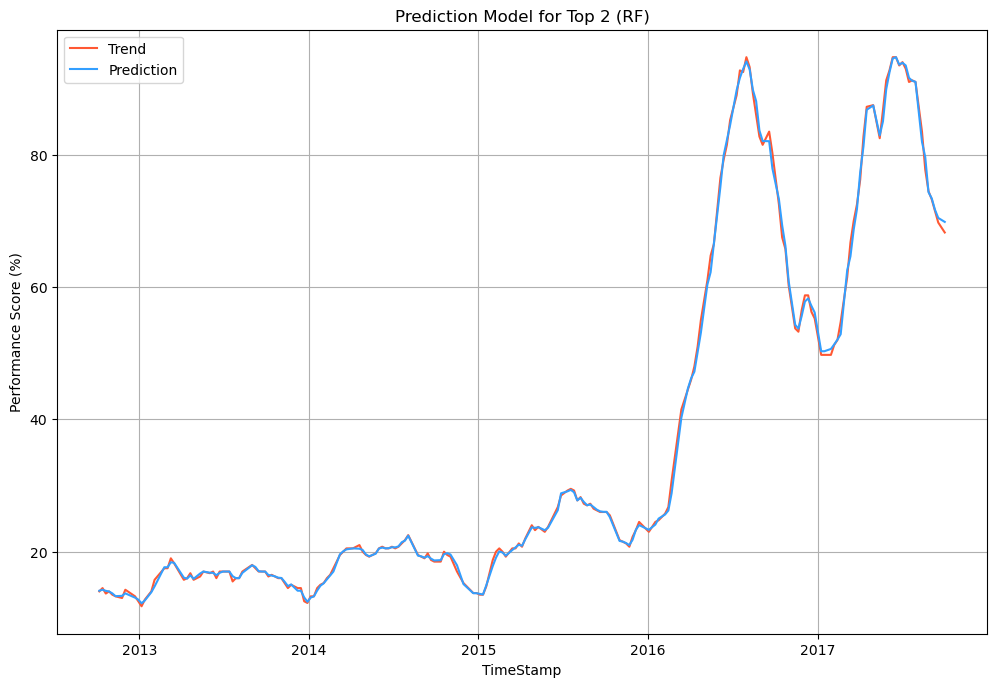

In [92]:
fig12 = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(dst_my_pred['timestamp'], dst_my_pred['original_trend_2'], label = "Trend", color = '#FF5833')
plt.plot(dst_my_pred['timestamp'], dst_my_pred['fitted_model_2'], label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 2 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

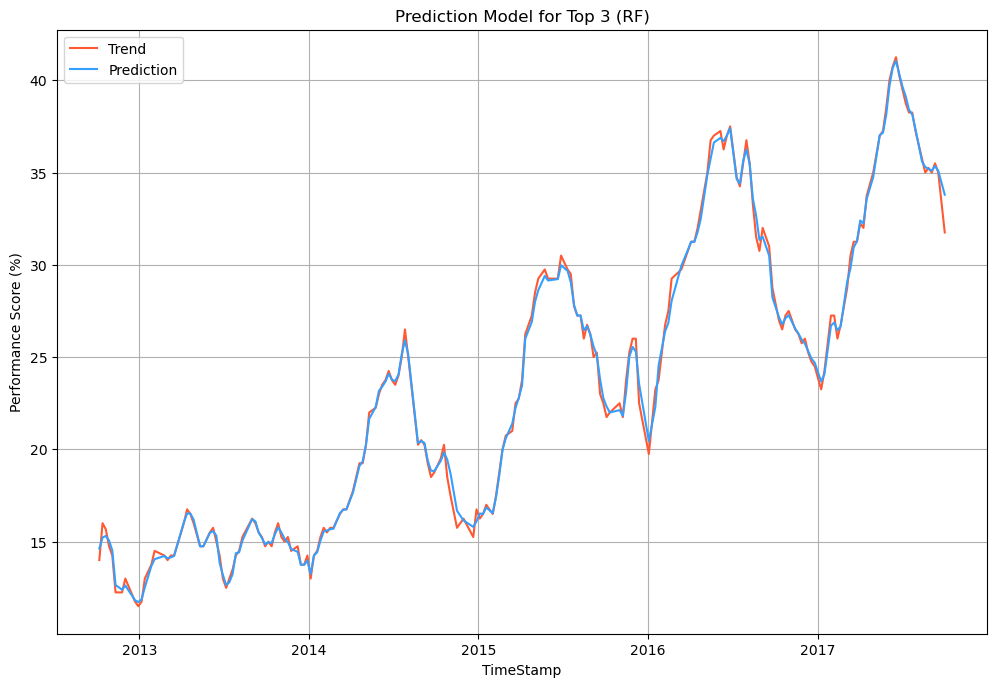

In [90]:
fig = plt.subplots(1, 1, figsize = (12, 8), dpi= 100)
plt.plot(dst_my_pred['timestamp'], dst_my_pred['original_trend_3'], label = "Trend", color = '#FF5833')
plt.plot(dst_my_pred['timestamp'], dst_my_pred['fitted_model_3'], label = "Prediction", color = '#339FFF')
plt.title('Prediction Model for Top 3 (RF)')
plt.xlabel('TimeStamp')
plt.ylabel('Performance Score (%)')
plt.legend()
plt.grid()
plt.show()

A few models such as Decision Tree or SVR were also tested but Random Forest seemed to outperformed all other models and hence it was chosen.

In [ ]:
dst_my_pred.to_csv('my prediction.csv')

##### [Back to Top](#backtop)

<a id = "Chapter3"> </a>
# BONUS

Annual Analysis Report Dashboard: [Here](https://public.tableau.com/app/profile/yapcl/viz/PracticeDashboard4_16478810233160/AnalysisReport?publish=yes)  
Business Intelligence Story: [Here](https://public.tableau.com/app/profile/yapcl/viz/PracticeStory4/AnalysisStory)

##### [Back to Top](#backtop)

<a id = "Chapter4"> </a>
# RNN LSTM Future Forecast

In [38]:
csv_file = 'trends1.csv'
df = pd.read_csv(csv_file)
df.drop(df.columns[[0]], axis=1, inplace = True)
df['date']= pd.to_datetime(df['date'])

In [40]:
df

,top 1,top 2,top 3,date
0,4,14,14,2012-10-07
1,7,15,18,2012-10-14
2,5,12,15,2012-10-21
3,5,15,12,2012-10-28
4,4,12,12,2012-11-04
...,...,...,...,...
256,18,72,35,2017-09-03
257,17,67,37,2017-09-10
258,18,66,32,2017-09-17
259,19,62,31,2017-09-24


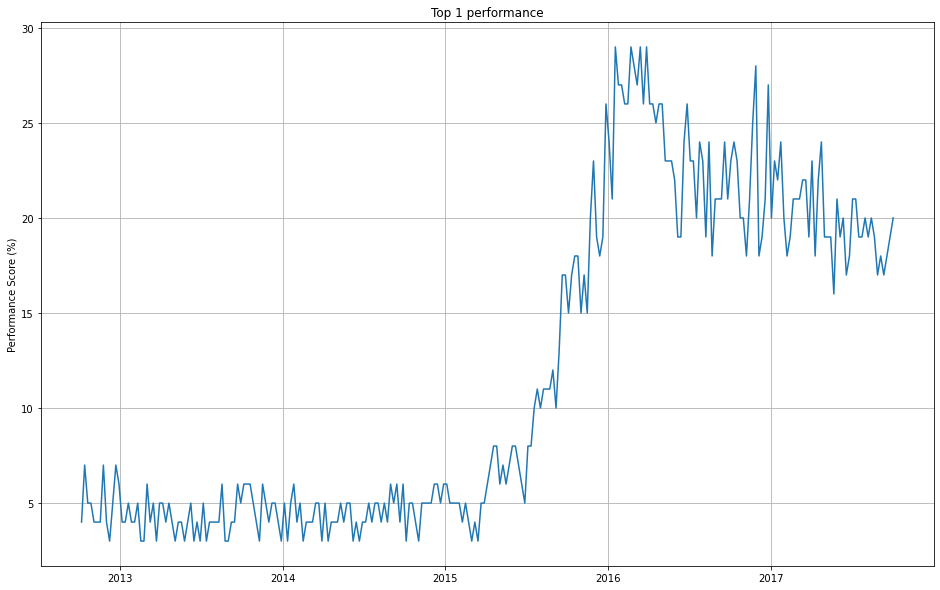

In [41]:
plt.figure(figsize=(16,10))
plt.plot(df['date'], df['top 1'])
plt.title('Top 1 performance')
plt.ylabel('Performance Score (%)')
plt.grid(True)
plt.show()

In [ ]:
dst['Year'] = dst['date'].dt.year
dst['Month'] = dst['date'].dt.month

In [43]:
dst_t_m = df.copy()
dst_t_m['Year'] = dst_t_m['date'].dt.year
dst_t_m['Month'] = dst_t_m['date'].dt.month
dst_t_m = dst_t_m.groupby(['Year','Month']).mean().reset_index()
dst_t_m['Date'] = pd.to_datetime(dst_t_m.assign(Day = 1).loc[:, ['Year','Month','Day']])

In [44]:
dst_t_m

,Year,Month,top 1,top 2,top 3,Date
0,2012,10,5.25,14.00,14.75,2012-10-01
1,2012,11,4.75,13.00,12.25,2012-11-01
2,2012,12,5.00,13.40,12.20,2012-12-01
3,2013,1,4.25,14.00,13.75,2013-01-01
4,2013,2,3.75,17.50,14.25,2013-02-01
...,...,...,...,...,...,...
56,2017,6,18.50,93.50,40.25,2017-06-01
57,2017,7,20.00,90.40,37.60,2017-07-01
58,2017,8,18.75,74.50,35.25,2017-08-01
59,2017,9,18.00,66.75,33.75,2017-09-01


In [45]:
y = df['top 1'].values.astype(float)

test_size = 14

train_set = y[:-test_size]
test_set = y[-test_size:]

In [52]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [53]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
train_norm = torch.FloatTensor(train_norm).view(-1)

In [54]:
train_norm

tensor([-0.9231, -0.6923, -0.8462, -0.8462, -0.9231, -0.9231, -0.9231, -0.6923,
        -0.9231, -1.0000, -0.8462, -0.6923, -0.7692, -0.9231, -0.9231, -0.8462,
        -0.9231, -0.9231, -0.8462, -1.0000, -1.0000, -0.7692, -0.9231, -0.8462,
        -1.0000, -0.8462, -0.8462, -0.9231, -0.8462, -0.9231, -1.0000, -0.9231,
        -0.9231, -1.0000, -0.9231, -0.8462, -1.0000, -0.9231, -1.0000, -0.8462,
        -1.0000, -0.9231, -0.9231, -0.9231, -0.9231, -0.7692, -1.0000, -1.0000,
        -0.9231, -0.9231, -0.7692, -0.8462, -0.7692, -0.7692, -0.7692, -0.8462,
        -0.9231, -1.0000, -0.7692, -0.8462, -0.9231, -0.8462, -0.8462, -0.9231,
        -1.0000, -0.8462, -1.0000, -0.8462, -0.7692, -0.9231, -0.8462, -1.0000,
        -0.9231, -0.9231, -0.9231, -0.8462, -0.8462, -1.0000, -0.8462, -1.0000,
        -0.9231, -0.9231, -0.9231, -0.8462, -0.9231, -0.8462, -0.8462, -1.0000,
        -0.9231, -1.0000, -0.9231, -0.9231, -0.8462, -0.9231, -0.8462, -0.8462,
        -0.9231, -0.8462, -0.9231, -0.76

In [55]:
def input_data(seq, ws):
    
    out = []
    L = len(seq)
    
    for i in range(L - ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    
    return out

In [56]:
window_size = 14

train_data = input_data(train_norm, window_size)

In [57]:
class LSTMnetwork(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        
        super().__init__()
        
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.fc1 = nn.Linear(hidden_size,output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.fc1(lstm_out.view(len(seq),-1))
        
        return pred[-1]

In [58]:
torch.manual_seed(42)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [60]:
epochs = 100

start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.03348291
Epoch:  2 Loss: 0.01844847
Epoch:  3 Loss: 0.01574151
Epoch:  4 Loss: 0.01396729
Epoch:  5 Loss: 0.01331229
Epoch:  6 Loss: 0.01245241
Epoch:  7 Loss: 0.01159690
Epoch:  8 Loss: 0.01040245
Epoch:  9 Loss: 0.00914527
Epoch: 10 Loss: 0.00762856
Epoch: 11 Loss: 0.00619561
Epoch: 12 Loss: 0.00540254
Epoch: 13 Loss: 0.00472042
Epoch: 14 Loss: 0.00442476
Epoch: 15 Loss: 0.00464151
Epoch: 16 Loss: 0.00274498
Epoch: 17 Loss: 0.00350831
Epoch: 18 Loss: 0.00183069
Epoch: 19 Loss: 0.00154186
Epoch: 20 Loss: 0.00120855
Epoch: 21 Loss: 0.00093113
Epoch: 22 Loss: 0.00061900
Epoch: 23 Loss: 0.00065359
Epoch: 24 Loss: 0.00042526
Epoch: 25 Loss: 0.00029022
Epoch: 26 Loss: 0.00023265
Epoch: 27 Loss: 0.00007433
Epoch: 28 Loss: 0.00002230
Epoch: 29 Loss: 0.00010920
Epoch: 30 Loss: 0.00260196
Epoch: 31 Loss: 0.00001717
Epoch: 32 Loss: 0.00040472
Epoch: 33 Loss: 0.00000205
Epoch: 34 Loss: 0.00057214
Epoch: 35 Loss: 0.00003984
Epoch: 36 Loss: 0.00034928
Epoch: 37 Loss: 0.00082066
E

In [61]:
future = 14

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [62]:
my_y_pred = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [63]:
my_y_pred

array([[19.40812886],
       [20.04232341],
       [19.27875933],
       [18.72414798],
       [17.9113144 ],
       [20.59691849],
       [21.02902868],
       [18.9946405 ],
       [20.27716577],
       [18.92993191],
       [21.92384869],
       [21.28977153],
       [20.49898311],
       [20.83647937]])

In [64]:
df['top 1'][-14:]

247    21
248    21
249    19
250    19
251    20
252    19
253    20
254    19
255    17
256    18
257    17
258    18
259    19
260    20
Name: top 1, dtype: int64

In [68]:
my_x = np.arange('2016-09-01', "2017-11-01", dtype = 'datetime64[M]').astype('datetime64[D]')

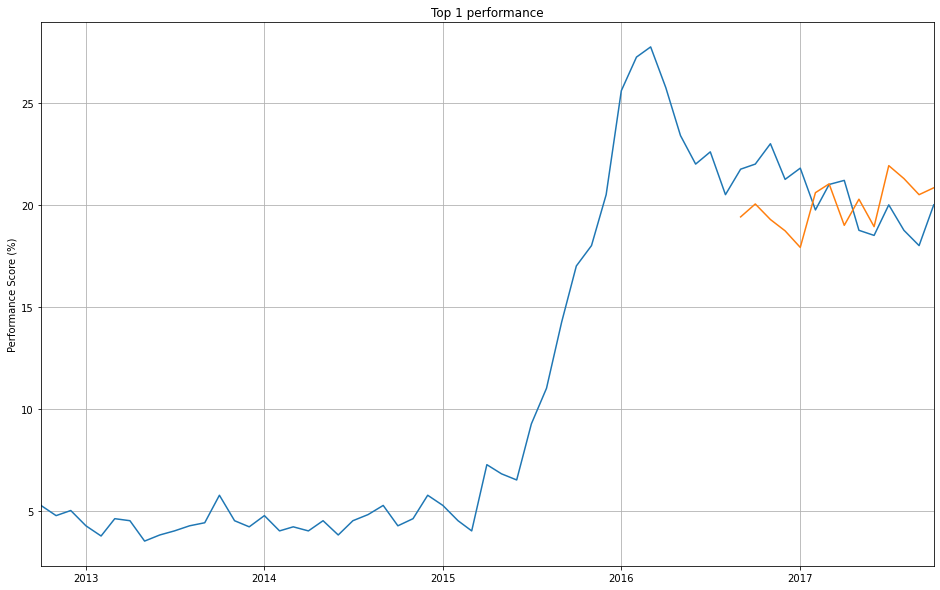

In [77]:
plt.figure(figsize=(16,10))
plt.plot(dst_t_m['Date'], dst_t_m['top 1'])
plt.plot(my_x,my_y_pred)
plt.title('Top 1 performance')
plt.ylabel('Performance Score (%)')
plt.autoscale(axis='x',tight=True)
plt.grid(True)
plt.show()

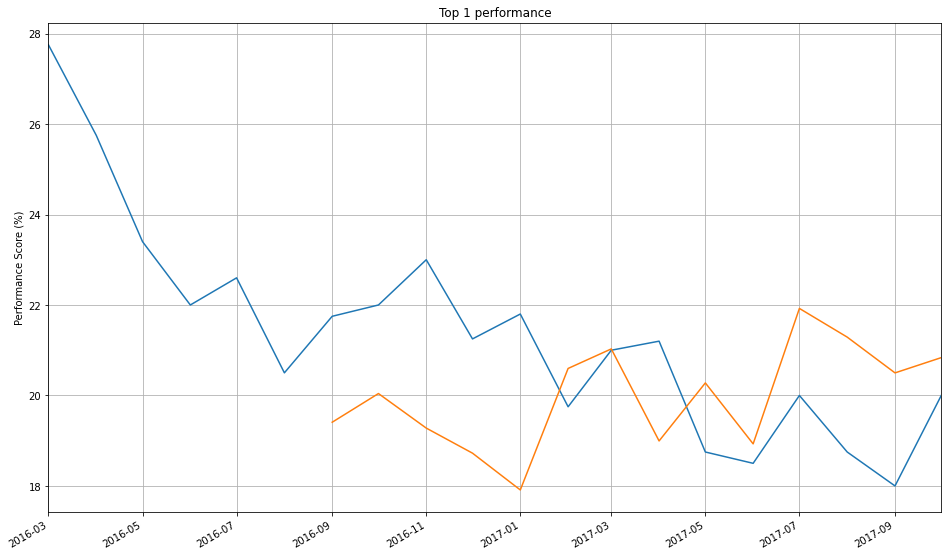

In [86]:
fig = plt.figure(figsize=(16,10))
plt.plot(dst_t_m['Date'][-20:], dst_t_m['top 1'][-20:])
plt.plot(my_x,my_y_pred)
plt.title('Top 1 performance')
plt.ylabel('Performance Score (%)')
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.grid(True)
plt.show()

In [87]:
epochs = 100

model.train()

y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size)

start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in all_data:  
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00278130
Epoch:  2 Loss: 0.01463627
Epoch:  3 Loss: 0.00396059
Epoch:  4 Loss: 0.01519167
Epoch:  5 Loss: 0.01036920
Epoch:  6 Loss: 0.01683810
Epoch:  7 Loss: 0.00918921
Epoch:  8 Loss: 0.01389767
Epoch:  9 Loss: 0.01272677
Epoch: 10 Loss: 0.01635733
Epoch: 11 Loss: 0.00922373
Epoch: 12 Loss: 0.01618556
Epoch: 13 Loss: 0.01343095
Epoch: 14 Loss: 0.01268007
Epoch: 15 Loss: 0.01361548
Epoch: 16 Loss: 0.01397908
Epoch: 17 Loss: 0.01296779
Epoch: 18 Loss: 0.01147766
Epoch: 19 Loss: 0.01044596
Epoch: 20 Loss: 0.01113747
Epoch: 21 Loss: 0.02303823
Epoch: 22 Loss: 0.00951963
Epoch: 23 Loss: 0.01066724
Epoch: 24 Loss: 0.00911416
Epoch: 25 Loss: 0.00833260
Epoch: 26 Loss: 0.00655818
Epoch: 27 Loss: 0.00682423
Epoch: 28 Loss: 0.00393439
Epoch: 29 Loss: 0.00620990
Epoch: 30 Loss: 0.00301888
Epoch: 31 Loss: 0.00946901
Epoch: 32 Loss: 0.01316541
Epoch: 33 Loss: 0.00613150
Epoch: 34 Loss: 0.00726536
Epoch: 35 Loss: 0.01094015
Epoch: 36 Loss: 0.01353339
Epoch: 37 Loss: 0.00731472
E

In [88]:
future = 14
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):  
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

In [93]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
x = np.arange('2017-11-01', '2019-01-01', dtype='datetime64[M]').astype('datetime64[D]')

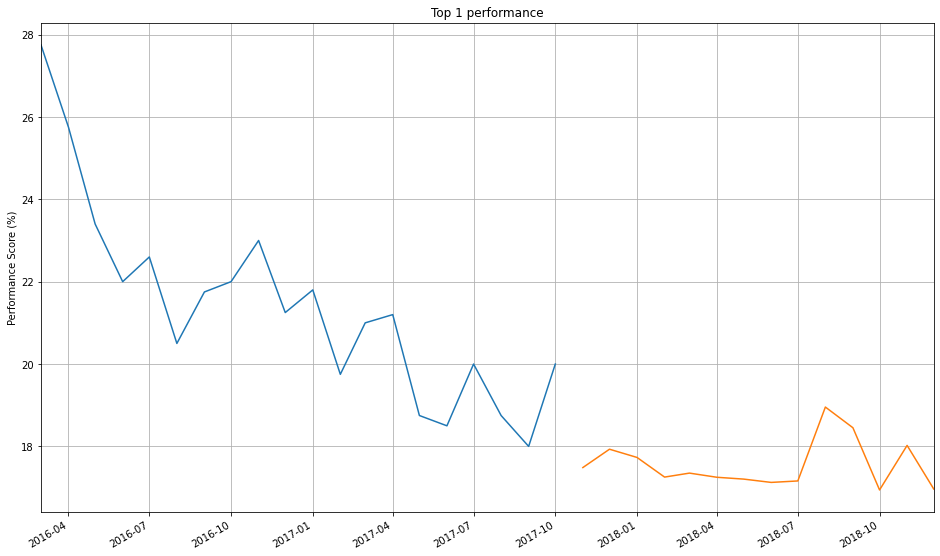

In [94]:
fig = plt.figure(figsize=(16,10))
plt.plot(dst_t_m['Date'][-20:], dst_t_m['top 1'][-20:])
plt.plot(x, true_predictions[window_size:])
plt.title('Top 1 performance')
plt.ylabel('Performance Score (%)')
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.grid(True)
plt.show()

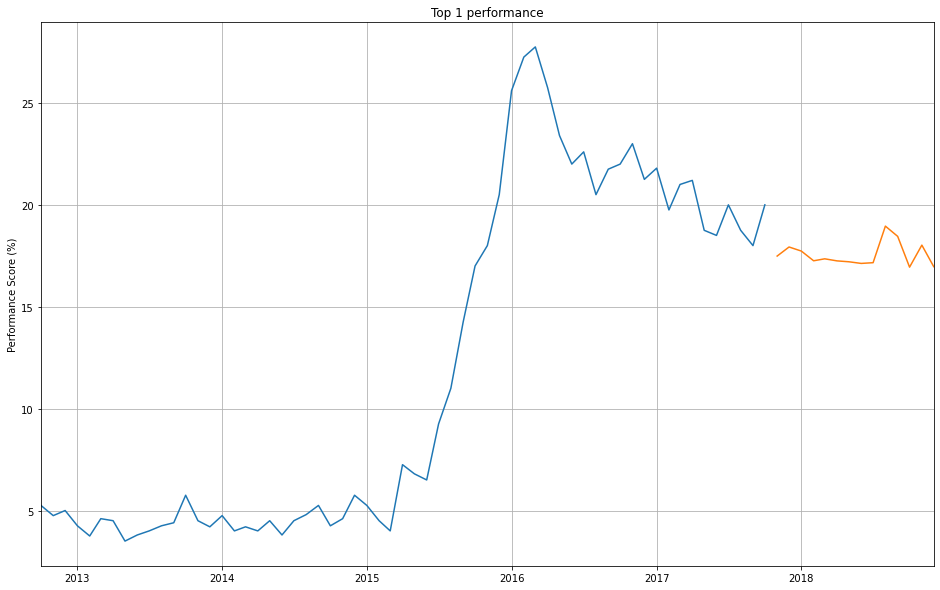

In [95]:
plt.figure(figsize=(16,10))
plt.plot(dst_t_m['Date'], dst_t_m['top 1'])
plt.plot(x, true_predictions[window_size:])
plt.title('Top 1 performance')
plt.ylabel('Performance Score (%)')
plt.autoscale(axis='x',tight=True)
plt.grid(True)
plt.show()

##### [Back to Top](#backtop)